## Create Edits that match post edit class distribution of target class to real edits

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [67]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, informal_log, write_lists
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import histogram
from utils.model_utils import prepare_device, quick_predict
from parse_config import ConfigParser
from test import predict
import datasets.datasets as module_data
import model.model as module_arch
import model.metric as module_metric
import model.loss as module_loss

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')

config_path = 'configs/copies/edit_experiments/cinic10_imagenet-bump_edit.json'

In [4]:
# Load config file, models, and dataloader
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

config_dict = read_json(config_path)

device, device_ids = prepare_device(config_dict['n_gpu'])

### Get the Target Class Distribution Across All Edits for Specific Class

In [54]:
target_class_name = 'cat'
target_class_idx = class_idx_dict[target_class_name]
n_select = 100
timestamp = '0127_103716'
save_timestamp = '0208_112555'

root_dir = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', '{}' + '_{}'.format(n_select), timestamp)
csv_path_template = os.path.join(root_dir, 'results_table.csv')


In [79]:
def save_class_distribution(csv_path, 
                            target_class_idx,
                            target_class_name,
                            show=False):
    
    df = load_and_preprocess_csv(
        csv_path=csv_path,
        drop_duplicates=['ID']
    )
    
    # Obtain number of predictions for target class pre edit
    pre_edit_class_distribution = df['Pre Class Dist'].to_numpy()
    pre_edit_class_distribution = np.stack(pre_edit_class_distribution)
    target_pre_edit_class_predictions = np.mean(pre_edit_class_distribution[:, target_class_idx])
    
    # Obtain number of predictions for target class post edit for each trial
    class_distribution = df['Post Class Dist'].to_numpy()
    class_distribution = np.stack(class_distribution, axis=0)
    target_class_distribution = class_distribution[:, target_class_idx]
    # target_class_bins = np.bincount(target_class_distribution)

    histogram_save_path = os.path.join(os.path.dirname(csv_path), 'graphs', 'summary', 'target_class_distribution.png')
    title = 'Post Edit {} Class Distribution for {} Edits'.format(target_class_name, target_class_name)
    xlabel = 'Num. {} Predictions Post Edit'.format(target_class_name)
    ylabel = 'Num. Edits'
    
    bin_values, bins, _ = histogram(
        data=target_class_distribution,
        n_bins=50,
        save_path=histogram_save_path,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        marker=target_pre_edit_class_predictions,
        show=show)
    
    bin_tuples = []
    for bin_idx in range(len(bins) - 1):
        bin_tuples.append((bins[bin_idx], bins[bin_idx+1]))

    save_data = {
        "n_target_predictions": target_class_distribution,
        "histogram_bin_values": bin_values,
        "histogram_bins": bins
    }
    target_class_dist_save_path = os.path.join(os.path.dirname(csv_path), 'target_class_distribution.pth')
    torch.save(save_data, target_class_dist_save_path)
    
    print("Saved target class distribution & histogram data to {}".format(target_class_dist_save_path))
    
    plt.close('all')
    return save_data

#### Loop over all classes and save histograms and distributions

In [ ]:
for class_name in class_list:
    csv_path = csv_path_template.format(class_name)
    save_class_distribution(
        csv_path=csv_path,
        target_class_idx=class_idx_dict[class_name],
        target_class_name=class_name,
        show=False)
    

### For a specific class, make bump edits that match the distribution of target class prediction

In [46]:
# Load datasets
config = ConfigParser(config_dict)
data_loader_args = dict(config.config["data_loader"]["args"])
dataset_args = dict(config["dataset_args"])

val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Obtain loss function and metric functions
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

In [ ]:
# Load model
layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum, device=device)
model.eval()


In [48]:
def predict_with_bump(data_loader,
                      model,
                      target_class_idx,
                      bump_amount,
                      loss_fn,
                      metric_fns,
                      device,
                      save_path=None):
    '''
    Run the model on the data_loader, calculate metrics, and log

    Arg(s):
        data_loader : torch Dataloader
            data to test on
        model : torch.nn.Module
            model to run
        loss_fn : module
            loss function
        metric_fns : list[model.metric modules]
            list of metric functions
        device : torch.device
        save_path : str or None
            if not None, save metrics to save_path

    Returns :
        log : dict{} of metrics
    '''

    # Hold data for calculating metrics
    outputs = []
    targets = []

    # Ensure model is in eval mode
    if model.training:
        model.eval()

    with torch.no_grad():
        for idx, item in enumerate(tqdm(data_loader)):
            if len(item) == 3:
                data, target, path = item
            else:
                data, target = item
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Store outputs and targets
            outputs.append(output)
            targets.append(target)

    # Concatenate predictions and targets
    outputs = torch.cat(outputs, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # Adjust output softmax by bump amount
    outputs[:, target_class_idx] += bump_amount

    # Calculate loss
    loss = loss_fn(outputs, targets).item()
    n_samples = len(data_loader.sampler)
    log = {'loss': loss}

    # Calculate predictions based on argmax
    predictions = torch.argmax(outputs, dim=1)

    # Move predictions and target to cpu and convert to numpy to calculate metrics
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()

    # Calculate metrics
    log = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=predictions,
        target=targets)

    if save_path is not None:
        ensure_dir(os.path.dirname(save_path))
        torch.save(log, save_path)

    return log

In [51]:
def match_bump_edits(data_loader,
                     model,
                     loss_fn,
                     metric_fns,
                     device,
                     bin_lows,
                     target_class_idx,
                     save_dir,
                     debug=True):
    '''
    Get bins
    for each bin, get the mean
    until the target class predictions on val match the mean,
        adjust the target
    store (mean, bump amount)
    '''
    # save_dir = os.path.dirname(str(config.save_dir))
    informal_log_path = os.path.join(save_dir, 'informal_log.txt')
    bump_dictionary = {}
    
    n_bins = len(bin_lows) - 1
    
    n_bins_left = n_bins
    min_bin = bin_lows[0]
    bin_width = bin_lows[1] - bin_lows[0]
    
    bin_means = []
    bump_amount = 0.2
    delta = 1.25
    
    bumps = [-1 for i in range(n_bins)]
    class_predictions = [-1 for i in range(n_bins)]
    logs = [None for i in range(n_bins)]
    
    cur_bump_idx = 0
    cur_itr = 0
    delta_reset = 1.25
    
    # Obtain pre edit metrics
    pre_edit_log = predict(
        data_loader=data_loader,
        model=model,
        loss_fn=loss_fn,
        metric_fns=metric_fns,
        device=device,
        save_path=None)

    while cur_bump_idx < n_bins:
        cur_itr += 1
        if delta <= 1 or delta > 2:
            delta = delta_reset
        if debug:
            informal_log("[{}]***NEW ITR {}***".format(
                datetime.now().strftime(r'%m%d_%H%M%S'), cur_itr), informal_log_path)

        if bumps[cur_bump_idx] > -1:
            bump_amount = bumps[cur_bump_idx]
            cur_bump_idx += 1
            
            continue
        
        log = predict_with_bump(
            data_loader=data_loader,
            model=model,
            loss_fn=loss_fn,
            metric_fns=metric_fns,
            device=device,
            target_class_idx=target_class_idx,
            bump_amount=bump_amount,
            save_path=None)
        
        # Obtain num. predictions for target class and determine bin idx
        post_class_distribution = log['predicted_class_distribution']
        target_class_predictions = post_class_distribution[target_class_idx]
        bin_idx = math.floor((target_class_predictions - min_bin) / bin_width)
        
        # Check for out of bounds/already visited bin index
        while bin_idx < cur_bump_idx:
            bump_amount *= delta
            if debug:
                informal_log("bin_idx < cur_bump_idx ({} and {}) delta={} new bump_amount: {}".format(
                    bin_idx, cur_bump_idx, delta, bump_amount), informal_log_path)
                
            log = predict_with_bump(
                data_loader=data_loader,
                model=model,
                loss_fn=loss_fn,
                metric_fns=metric_fns,
                device=device,
                target_class_idx=target_class_idx,
                bump_amount=bump_amount,
                save_path=None)

            # Obtain num. predictions for target class and determine bin idx
            post_class_distribution = log['predicted_class_distribution']
            target_class_predictions = post_class_distribution[target_class_idx]
            bin_idx = math.floor((target_class_predictions - min_bin) / bin_width)
                
            
            # continue
        if bin_idx >= n_bins:
            if cur_bump_idx == 0:
                bump_amount /= delta
            else:
                bump_amount = (bump_amount + bumps[cur_bump_idx - 1]) / 2
            informal_log("bin_idx > n_bins ({}) delta={} new bump_amount: {}".format(
                bin_idx, delta, bump_amount), informal_log_path)
            continue
            
        # Sanity check correct bin_idx
        assert target_class_predictions >= bin_lows[bin_idx] and \
               target_class_predictions <= bin_lows[bin_idx+1]
        
        # If bump value for this bin yet, assign it
        if bumps[bin_idx] == -1:
            bumps[bin_idx] = bump_amount
            class_predictions[bin_idx] = target_class_predictions
            logs[bin_idx] = log
            if debug:
                informal_log("assigned bin_idx {}".format(bin_idx), informal_log_path)
                informal_log("Cur bump_idx: {} bump amount: {} target_class_pred: {} bin_idx: {}".format(
                    cur_bump_idx, bump_amount, target_class_predictions, bin_idx), informal_log_path)
        
        # Check if this is our current bin we're trying to fill
        if bin_idx == cur_bump_idx:
            cur_bump_idx += 1
            bump_amount *= delta
            if debug:
                informal_log("updating cur_bump_idx to {}, bump_amount to {}"
                             .format(cur_bump_idx, bump_amount), informal_log_path)
            
        # If we're not at the current cell,
        else:
            # Decrease bump amount by half
            if cur_bump_idx == 0:
                bump_amount /= 2
            # Set bump amount to something in the middle between current and last successful
            else:
                bump_amount = (bump_amount + bumps[cur_bump_idx-1]) / 2 
            if debug:
                informal_log("Overshot to bin {}. Decreasing bump amount to {} aiming for bin {}".format(
                    bin_idx, bump_amount, cur_bump_idx), informal_log_path)
        informal_log("bumps: {}".format(bumps), informal_log_path)

    
    
    save_data = {
        'pre_edit_metrics': pre_edit_log,
        'bump_amounts': bumps,
        'target_class_predictions': class_predictions,
        'metrics': logs
    }
    save_path = os.path.join(save_dir, 'bumps_preds_metrics.pth'.format())
    torch.save(save_data, save_path)
    if debug:
        informal_log("Saved data to {}".format(save_path), informal_log_path)
    return save_data
            

#### Run match_bump_edits() to get how much to bump to match each bucket

In [81]:
target_class_distribution_path = os.path.join(root_dir, 'target_class_distribution.pth').format(
    target_class_name)
target_class_distribution = torch.load(target_class_distribution_path)
bin_lows = target_class_distribution['histogram_bins']

bump_save_dir = os.path.join(os.path.dirname(os.path.dirname(config.save_dir)), save_timestamp, '{}_{}'.format(target_class_name, n_select))

# Save a copy of histogram info to save_dir
torch.save(target_class_distribution, os.path.join(bump_save_dir, 'target_class_distribution.pth'))
# Run bump experiments
print("Obtaining class distribution for {} from {}".format(target_class_name, target_class_distribution_path))
print("Saving results to {}".format(bump_save_dir))
match_bump_edits(
    data_loader=val_paths_data_loader,
    model=model,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    device=device,
    bin_lows=bin_lows,
    target_class_idx=target_class_idx,
    save_dir=bump_save_dir)

Obtaining class distribution for cat from saved/edit/trials/CINIC10_ImageNet-VGG_16/cat_100/0127_103716/target_class_distribution.pth
Saving results to saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/cat_100


#### Sanity check that resulting histogram matches original from real edits

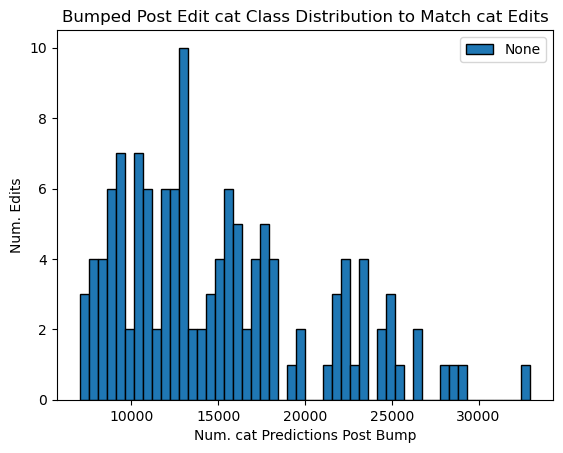

<Figure size 640x480 with 0 Axes>

In [87]:
bump_save_dir = os.path.join(os.path.dirname(os.path.dirname(config.save_dir)), save_timestamp, '{}_{}'.format(target_class_name, n_select))
metrics_save_path = os.path.join(bump_save_dir, 'bumps_preds_metrics.pth')

bumped_target_class_dist = torch.load(metrics_save_path)

bumped_hist_data = []


target_class_dist_dict = torch.load(target_class_distribution_path)

for n_target_predictions, bucket_value in zip(
    bumped_target_class_dist['target_class_predictions'], 
    target_class_distribution['histogram_bin_values']):
    cur_data = [n_target_predictions for i in range(int(bucket_value))]
    bumped_hist_data += cur_data
    
bins = target_class_distribution['histogram_bins']
bin_values = target_class_distribution['histogram_bin_values']

histogram_save_path = os.path.join(
    bump_save_dir, 
    'graphs',
    'summary',
    'bumped_target_class_distribution.png')
bump_bin_values, bump_bins, _= histogram(
        data=bumped_hist_data,
        n_bins=bins, #50,
        title='Bumped Post Edit {} Class Distribution to Match {} Edits'.format(target_class_name, target_class_name),
        xlabel='Num. {} Predictions Post Bump'.format(target_class_name),
        ylabel='Num. Edits',
        save_path=histogram_save_path,
        show=True)

assert (bin_values == bump_bin_values).all()

#### Copy results such that we can call src/utils/results_to_csv.py to get csv of results

In [73]:
def create_bump_results(bumps_preds_metrics,
                        target_class_distribution,
                        results_save_dir,
                        trial_paths_path):
    '''
    Given how much to bump logit by to match target class distribution, create results for each tiral
    
    Arg(s):
        bumps_preds_metrics : dict
            result of match_bump_edits()
        target_class_distribution : dict
            histogram data, result from save_class_distribution()
        results_save_dir : str
            location of results folder
        trial_paths_path : str
            path to file to store paths to each trial
            
    '''
    pre_edit_metrics = bumps_preds_metrics['pre_edit_metrics']
    
    metrics = bumps_preds_metrics['metrics']
    bin_values = target_class_distribution['histogram_bin_values']
    bins = target_class_distribution['histogram_bins']
    bin_lows = bins[:-1]
    bin_highs = bins[1:]

    trial_paths = []
    for bin_idx, bin_value in enumerate(bin_values):
        n_repeat = int(bin_value)
        if n_repeat == 0:
            continue
            
        # Obtain post edit metrics
        post_edit_metrics = metrics[bin_idx]
        
        for itr in range(n_repeat):
            # Create directory for this trial
            trial_id = 'bin_{}_{}_itr_{}'.format(bin_lows[bin_idx], bin_highs[bin_idx], itr)
            trial_dir = os.path.join(results_save_dir, trial_id)
            ensure_dir(trial_dir)
            # Log path to trial_paths.txt
            trial_paths.append(trial_dir)
            
            # Save pre edit metrics
            torch.save(pre_edit_metrics, os.path.join(trial_dir, 'models', 'pre_edit_metrics.pth'))
            # Save post edit metrics
            torch.save(post_edit_metrics, os.path.join(trial_dir, 'models', 'post_edit_metrics.pth'))
        
    return trial_paths

In [74]:
bump_preds_metrics_path = os.path.join(bump_save_dir, 'bumps_preds_metrics.pth')
target_class_distribution_path = os.path.join(bump_save_dir, 'target_class_distribution.pth')

# Load objects
bumps_preds_metrics = torch.load(bump_preds_metrics_path)
target_class_distribution = torch.load(target_class_distribution_path)

results_save_dir = os.path.join(bump_save_dir, 'results')
ensure_dir(results_save_dir)
progress_report_path = os.path.join(bump_save_dir, 'progress_report.txt')
trial_paths_path = os.path.join(bump_save_dir, 'trial_paths.txt')
# Remove file at trial_paths_path if it exists
if os.path.isfile(trial_paths_path):
    os.remove(trial_paths_path)

trial_paths = create_bump_results(
    bumps_preds_metrics=bumps_preds_metrics,
    target_class_distribution=target_class_distribution,
    results_save_dir=results_save_dir,
    trial_paths_path=trial_paths_path)

write_lists(trial_paths_path, trial_paths)
print("Wrote list of trial_paths to {}".format(trial_paths_path))

Wrote list of trial_paths to saved/edit/experiments/bump_edits/CINIC10_ImageNet-VGG_16/0208_112555/cat_100/trial_paths.txt
